
# Group Sparse inverse covariance for multi-subject connectome

This example shows how to estimate a connectome on a group of subjects
using the group sparse inverse covariance estimate.

.. include:: ../../../examples/masker_note.rst


In [1]:
# Libraries and Paths
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import logging

# Paths and parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = ['sub-084']
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()


In [2]:
import numpy as np

from nilearn import plotting

n_subjects = 18  # subjects to consider for group-sparse covariance (max: 40)


def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing."""
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        labels=labels,
    )
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        labels=labels,
    )

## Fetching datasets



In [3]:
from nilearn import datasets

# Instead of MSDL atlas, use Schaefer
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)

# Create our dataset structure
func_filenames = []
for sub in subs:  # using subs from your sub_info loading
    subject_runs = [
        f'{raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
        for run in [1, 2, 3]
    ]
    func_filenames.extend(subject_runs)
    
# print basic information on the dataset
print(f"First subject functional nifti image (4D) is at: {func_filenames[0]}")

# Print all subjects and their runs
#for i, filename in enumerate(func_filenames):
#    print(f"Subject functional nifti image {i} (4D) is at: {filename}")


First subject functional nifti image (4D) is at: /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz


In [4]:
no need to run again (sub-084 has been removed)
from nilearn.maskers import NiftiMapsMasker

# masker
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(
    labels_img='/home/csimmon2/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
    standardize='zscore_sample',
    detrend=True,
    high_pass=0.01,
    t_r=2,
    verbose=1,
    memory=None
)

masker.fit()

# Your existing loop for all subjects
subject_time_series = []
for func_filename in func_filenames:
    print(f"Processing file {func_filename}")
    region_ts = masker.transform(func_filename)
    subject_time_series.append(region_ts)


[NiftiLabelsMasker.fit] loading data from /home/csimmon2/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Processing file /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Processing file /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-02_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-02_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] 

## Computing group-sparse precision matrices



In [15]:
# claude n=18

# Libraries and Paths
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
from nilearn.image import concat_imgs
import logging
import time

start_time = time.time()

# Process all subjects instead of test subset
subject_time_series = []
for sub in subs:
    print(f"Processing subject {sub}")
    runs = [f'{raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz' 
            for run in [1, 2, 3]]
    concat_data = concat_imgs(runs)
    time_series = masker.transform(concat_data)
    subject_time_series.append(time_series)
    print(f"Finished processing subject {sub}")

# Fit GroupSparseCovarianceCV
print("Starting GroupSparseCovarianceCV fitting...")
gsc = GroupSparseCovarianceCV(verbose=2, n_jobs=-1)
gsc.fit(subject_time_series)

print(f"Total run time: {(time.time() - start_time)/60:.2f} minutes")

# Save results
np.save(f'{results_dir}/group_sparse_covariances.npy', gsc.covariances_)
np.save(f'{results_dir}/group_sparse_precisions.npy', gsc.precisions_)

Processing subject sub-025
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 552),
affine=array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Finished processing subject sub-025
Processing subject sub-038
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 552),
affine=array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Finished processing subject sub-038
Processing subject sub-057
[NiftiLabelsMasker.transform_single_imgs] Loading data from

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 14
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 16
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 15
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 15
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 12
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 13
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 12
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 14
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 14


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 19.1min remaining: 12.8min


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 49


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.7min finished


[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  0 out of 4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 17.5min remaining: 11.7min


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.7min finished


[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 23
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 23
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 22
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 28
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 28
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 22
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 23
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 25
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 24
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 25


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 49
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 48


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_s

[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/

[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 1
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0
[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 42.6min remaining: 28.4min
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


[EarlyStopProbe.__call__] Log-likelihood on test set is decreasing. Stopping at iteration 0


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 56.9min finished


[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4
[GroupSparseCovarianceCV.fit] Final optimization
Total run time: 181.78 minutes


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


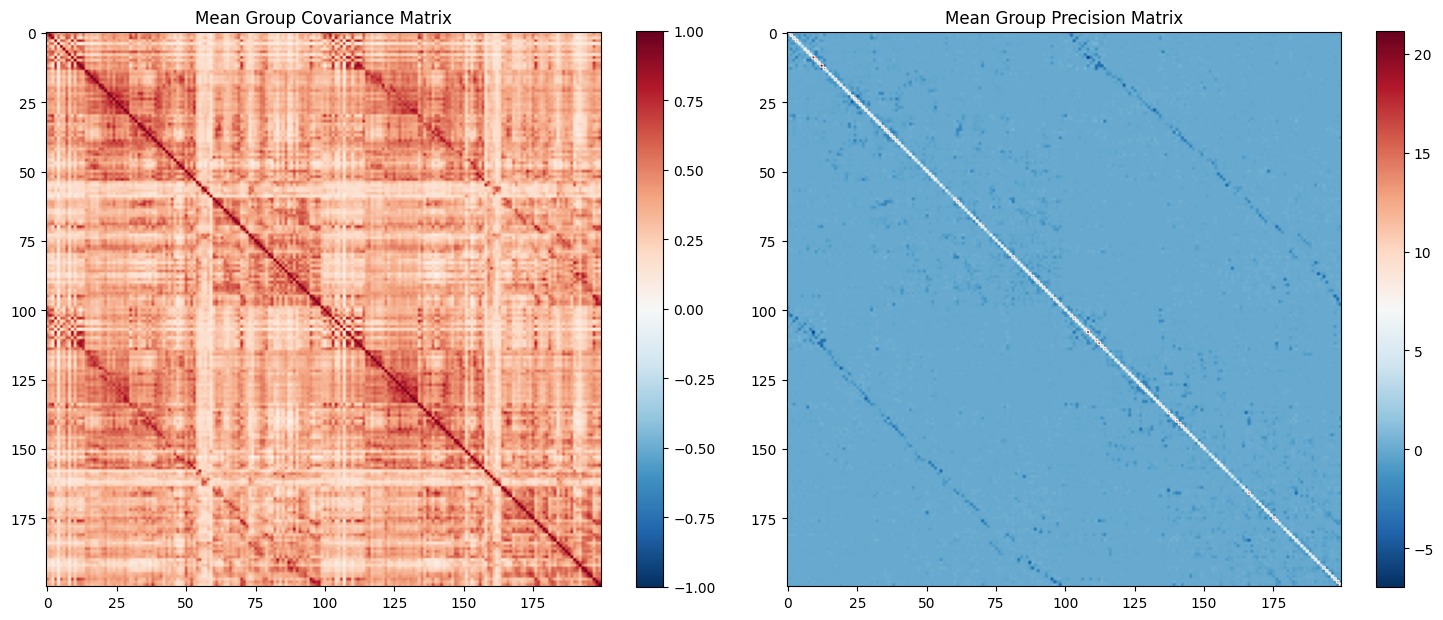

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Load saved matrices
precisions = np.load(f'{results_dir}/group_sparse_precisions.npy')
covariances = np.load(f'{results_dir}/group_sparse_covariances.npy')

# Calculate mean across subjects
mean_precision = np.mean(precisions, axis=-1)  
mean_covariance = np.mean(covariances, axis=-1)

# Plot
plt.figure(figsize=(15, 6))

# Covariance matrix
plt.subplot(121)
plt.imshow(mean_covariance, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Mean Group Covariance Matrix')

# Precision matrix
plt.subplot(122)
plt.imshow(mean_precision, cmap='RdBu_r')
plt.colorbar()
plt.title('Mean Group Precision Matrix')

plt.tight_layout()
plt.show()

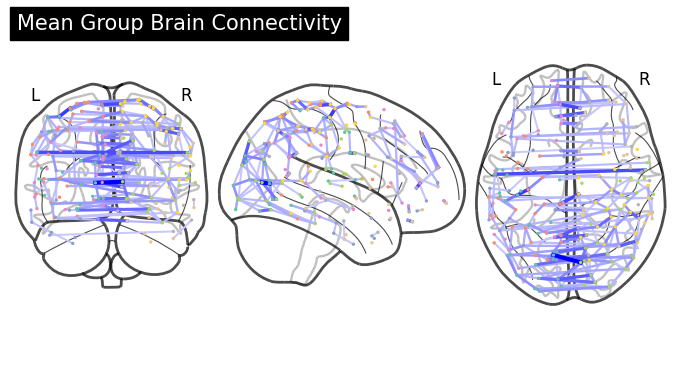

In [21]:
from nilearn.plotting import find_parcellation_cut_coords

# Get coordinates from the atlas map
atlas = fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
coords = find_parcellation_cut_coords(atlas.maps)

# Plot
plotting.plot_connectome(
   mean_precision,
   coords,
   node_size=2,
   edge_threshold='99%',
   title='Mean Group Brain Connectivity'
)
plt.show()

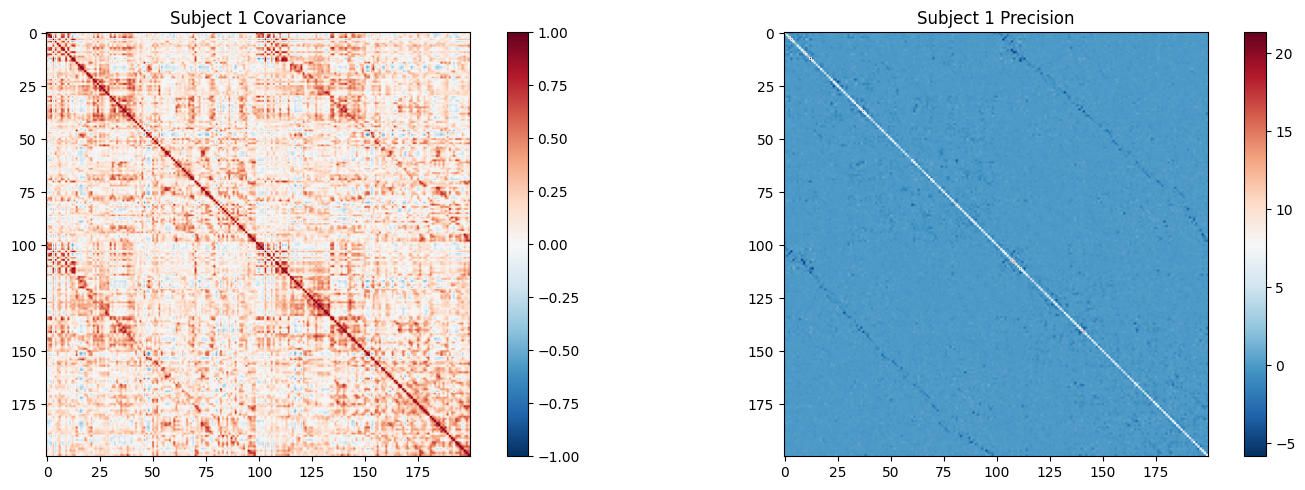

In [ ]:
# claude
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting, datasets

# Get node coordinates from atlas
atlas_img = nib.load('/home/csimmon2/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = atlas.labels

def plot_connectivity(covariances, precisions, subject_idx=0):
    plt.figure(figsize=(15, 5))
    
    # Covariance matrix
    plt.subplot(121)
    plt.imshow(covariances[..., subject_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Subject {subject_idx + 1} Covariance')
    
    # Precision matrix
    plt.subplot(122)
    plt.imshow(precisions[..., subject_idx], cmap='RdBu_r')
    plt.colorbar()
    plt.title(f'Subject {subject_idx + 1} Precision')
    
    plt.tight_layout()
    plt.show()

# Plot for first subject
plot_connectivity(gsc.covariances_, gsc.precisions_, subject_idx=0)

In [ ]:
#nilearn
from nilearn.connectome import GroupSparseCovarianceCV

gsc = GroupSparseCovarianceCV(
    verbose=5,
    max_iter=100  # note: parameter is max_iterations, not max_iter
)

gsc.fit(subject_time_series)

In [ ]:
#nilearn
from sklearn.covariance import GraphicalLassoCV

gl = GraphicalLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

## Displaying results



In [ ]:
#nilearn

atlas_img = atlas.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = atlas.labels

plotting.plot_connectome(
    gl.covariance_,
    atlas_region_coords,
    edge_threshold="90%",
    title="Covariance",
    display_mode="lzr",
)
plotting.plot_connectome(
    -gl.precision_,
    atlas_region_coords,
    edge_threshold="90%",
    title="Sparse inverse covariance (GraphicalLasso)",
    display_mode="lzr",
    edge_vmax=0.5,
    edge_vmin=-0.5,
)
plot_matrices(gl.covariance_, gl.precision_, "GraphicalLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(
    -gsc.precisions_[..., 0],
    atlas_region_coords,
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
    edge_vmax=0.5,
    edge_vmin=-0.5, 
)
plot_matrices(gsc.covariances_[..., 0], gsc.precisions_[..., 0], title, labels)

plotting.show()